In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib as mpl
import os

from IPython.core.pylabtools import figsize
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform, randint
from sklearn import base
from sklearn.model_selection import KFold

from IPython.core.pylabtools import figsize
from scipy import stats

In [92]:
#Getting Working Directory
os.getcwd()

#Setting style and font size for graphs
sns.set_style("whitegrid")
mpl.rcParams['font.size'] = 13

In [93]:
#load original data into dataframe
file ='train_study.csv'
df = pd.read_csv(file)
df.shape

(7377415, 38)

In [94]:
mem = df.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))

Memory consumed by training set  :   2138.8380432128906 MB


In [95]:
#df.drop('msno', axis=1, inplace = True)

df['isrc_year'] = df.isrc_year.apply(lambda x: x if x != 'year_missing' else -1)
df['isrc_year'] = df['isrc_year'].astype('int8')

#Converting to categories
cat_names = list(df.select_dtypes(include='object').columns)
df[cat_names] = df[cat_names].astype('category')
#df['language'] = df['language'].astype('category')

int_names = list(df.select_dtypes(include='int64').columns)
df[int_names] = df[int_names].astype('int32')

int_names_8 = ['composer_artist_lyricist', 'composer_artist']
df[int_names_8] = df[int_names_8].astype('uint8')


float_names = list(df.select_dtypes(include='float64').columns)
df[float_names] = df[float_names].astype('float32')

float_names = list(df.select_dtypes(include='float32').columns)
float_names.remove('song_length')
df[float_names] = df[float_names].astype('float16')

#ua = ['usr_1', 'usr_2', 'usr_3'] #, 'song_freq', 'ua_1', 'ua_2', 'ua_3','ua_4','ua_5','ua_6','ua_7','ua_8','ua_9','ua_10']
#df.drop(ua, axis=1, inplace = True)
#df.drop('artist_name_encoded', axis=1, inplace = True)

#df.info()

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377415 entries, 0 to 7377414
Data columns (total 38 columns):
msno                        category
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int32
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    float16
city                        int32
bd                          int32
gender                      category
registered_via              int32
name                        category
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_country                category
isrc_year                   int8
duration                    float16
registration_year           in

In [97]:
df.shape

(7377415, 38)

#### Train - Validation Split

In [98]:
from sklearn.model_selection import train_test_split

X  = df[:5500000]
X_valid = df[5500000:]
#X,X_valid = train_test_split(df, test_size = 0.5, random_state = 42)

In [99]:
X.shape

(5500000, 38)

#### Creating Features (User-Song)

In [100]:
matrix = X.drop(X.columns.difference(['msno','song_id','target']),axis = 1)

n_users = matrix.msno.unique().shape[0]
n_songs = matrix.song_id.unique().shape[0]

users = pd.DataFrame(matrix.msno.unique(), columns = ['msno'])
users['index'] = users.index
users.set_index('msno', inplace = True)
users = users.to_dict()['index']
matrix['msno_index'] =  matrix.msno.map(users)

songs = pd.DataFrame(matrix.song_id.unique(), columns = ['song'])
songs['index'] = songs.index
songs.set_index('song', inplace = True)
songs = songs.to_dict()['index']
matrix['song_index'] =  matrix.song_id.map(songs)

user_index = matrix.msno.unique()
matrix= matrix.drop(['msno', 'song_id'], axis = 1)
matrix.head()

,target,msno_index,song_index
0,1,0,0
1,1,1,1
2,1,1,2
3,1,1,3
4,1,0,4


In [101]:
from scipy.sparse import csc_matrix
user_song = csc_matrix((matrix.target, (matrix.msno_index, matrix.song_index)),(n_users,n_songs))
user_song

<27352x306546 sparse matrix of type '<class 'numpy.int32'>'
	with 5500000 stored elements in Compressed Sparse Column format>

0.1402015728982205


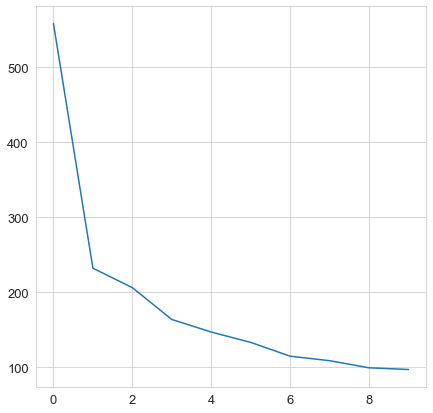

In [102]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd.fit(user_song)
print(svd.explained_variance_ratio_.sum())
plt.plot(svd.singular_values_)

In [103]:
user_index

[FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=, Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=, uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=, TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=, 3g0bC24RD7QUeALY1IF/e8L6X3fHG298ZFIsCEG9T9Y=, ..., Psmis8wJZlw/owhMCL1ls7FTpG0Y4g3tkpnCzGA22Ro=, YWt3yOeVQKAQDMwuWGpCKFWKCrjmLK/nWThwJc2Yzlc=, 5urlYlQ3G0MDj9ChVQj6ghmCEa1MLhyKJEDljMfx+SQ=, u5ljEXEBcljDdtdu03C7u9Nl4PxLHN925DufFAMQ0QA=, PyyYHk2SK1Q8akDBGe+skzAxrUZdCbNZGgieYJkOzSk=]
Length: 27352
Categories (27352, object): [FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=, Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=, uHqAtShXTRXju5GE8ri3ITsVFepPf8jUoCF7ffNOuqE=, TJU0Gfvy7FB+r89bWovPKXTjuApTCiv3xg/tt5shR78=, ..., YWt3yOeVQKAQDMwuWGpCKFWKCrjmLK/nWThwJc2Yzlc=, 5urlYlQ3G0MDj9ChVQj6ghmCEa1MLhyKJEDljMfx+SQ=, u5ljEXEBcljDdtdu03C7u9Nl4PxLHN925DufFAMQ0QA=, PyyYHk2SK1Q8akDBGe+skzAxrUZdCbNZGgieYJkOzSk=]

In [104]:
user_song_reduced = svd.transform(user_song)
col_name = ['us_'+str(i) for i in range(1,11)]
user_song_feat = pd.DataFrame(user_song_reduced, columns = col_name)
user_song_feat['msno'] = user_index

global_avg = user_song_reduced.mean(axis=0)

#train_enc.any()
X_enc = X

X_enc = X_enc.merge(user_song_feat, how = 'left', on = 'msno')
X_enc.index = X.index
X_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500000 entries, 0 to 5499999
Data columns (total 48 columns):
msno                        object
song_id                     category
source_system_tab           category
source_screen_name          category
source_type                 category
target                      int32
song_length                 float32
genre_ids                   category
artist_name                 category
composer                    category
lyricist                    category
language                    float16
city                        int32
bd                          int32
gender                      category
registered_via              int32
name                        category
lyricist_count              int32
artist_count                int32
composer_count              int32
genre_count                 int32
isrc_country                category
isrc_year                   int8
duration                    float16
registration_year           int3

In [105]:
X_valid_enc = X_valid

X_valid_enc = X_valid_enc.merge(user_song_feat, how = 'left', on = 'msno')
X_valid_enc.index = X_valid.index
X_valid_enc.sort_index().head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,us_1,us_2,us_3,us_4,us_5,us_6,us_7,us_8,us_9,us_10
5500000,o5aX6WqjLMIDK75c2riIpSvNgitb358m4yw3q41ZVzc=,KV8oVUZtLRECPbriR2F6PUwK1zB0cd3bc+4P6rmqAac=,discover,Online playlist more,online-playlist,1,284421.0,465,梁靜茹 (Fish Leong),composer_missing,...,9.256365,-0.297824,-2.047562,-0.686130,3.333349,0.525384,-0.847806,-0.638967,1.239803,-0.529948
5500001,o5aX6WqjLMIDK75c2riIpSvNgitb358m4yw3q41ZVzc=,M9rAajz4dYuRhZ7jLvf9RRayVA3os61X/XXHEuW4giA=,discover,Online playlist more,online-playlist,1,265848.0,465,林俊傑 (JJ Lin),JJ Lin,...,9.256365,-0.297824,-2.047562,-0.686130,3.333349,0.525384,-0.847806,-0.638967,1.239803,-0.529948
5500002,EBR1+Dr1bUF47Kpa4xK3LYLiHavXc8a7qOAuXaTEmf8=,BL6lAfWwGKth6fZVU/22IRFVPQ36v8SOjA/zgY9Tii8=,search,Search,song,1,311588.0,465,群星,陳家麗 /翁孝良,...,0.473069,-0.226131,-0.248547,-0.045558,0.017461,-0.219332,-0.095242,0.252370,0.052423,0.013006
5500003,MhZJkcYOrpqOJzHWfAlfEfGcQkD+qan/iNUo9cFdUVw=,aAoDgVo/aUVSDevLDajfNpS+HLKb4KUpMy1i+2dQMzg=,my library,Local playlist more,local-playlist,0,238422.0,458,王若琳 (Joanna Wang),Ralph MacDonald| William Salter| Bill Withers|...,...,3.849646,1.465602,-1.897536,0.440228,-1.731038,-2.279508,0.071265,-0.101991,0.088671,0.138951
5500004,MhZJkcYOrpqOJzHWfAlfEfGcQkD+qan/iNUo9cFdUVw=,kUMG87ZpsdHv0bKkC89kiQ0MVWCMpV7LgEDaJ7uEi0w=,my library,Local playlist more,local-playlist,0,187480.0,465,Various Artists,VIP,...,3.849646,1.465602,-1.897536,0.440228,-1.731038,-2.279508,0.071265,-0.101991,0.088671,0.138951


In [106]:
diff = list(set(df.msno.iloc[X_valid.index])-set(df.msno.iloc[X.index]))
diff_index = df[df.msno.isin(diff)].index
len(diff_index)

139439

In [107]:
#X_valid.index.sort_values()
#X.index.sort_values()
#diff_index.sort_values()

In [108]:
us = ['us_1','us_2','us_3','us_4','us_5','us_6','us_7','us_8', 'us_9','us_10']
X_valid_enc.loc[diff_index, us] = global_avg - 2

In [109]:
class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,smoothing=5,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
        self.smoothing = smoothing

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        
        
        kf = KFold(n_splits = self.n_fold)

        #Naming the column
        col_mean_name = self.colnames + '_' + 'encoded'
        X[col_mean_name] = np.nan

        
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            #print(tr_ind,val_ind) 
              
            enc = X_tr.groupby(self.colnames)[self.targetName].agg(['count', 'mean'])
            counts = enc['count']
            means = enc['mean']
            smooth = (counts * means + self.smoothing * mean_of_target) / (counts + self.smoothing)

            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(smooth)

            X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
            

        return X

In [110]:
target_encod_col = ['genre_ids', 'composer', 'artist_name', 'lyricist', 'name', 'isrc_country']
for col in target_encod_col:
    targetc = KFoldTargetEncoderTrain(col,'target',n_fold=5, discardOriginal_col=False )
    X_enc = targetc.fit_transform(X_enc)

Correlation between the new feature, genre_ids_encoded and, target is -0.005051561495131033.
Correlation between the new feature, composer_encoded and, target is 0.1242257876484534.
Correlation between the new feature, artist_name_encoded and, target is 0.12611694127279027.
Correlation between the new feature, lyricist_encoded and, target is 0.09275389845924073.
Correlation between the new feature, name_encoded and, target is 0.15910448012070819.
Correlation between the new feature, isrc_country_encoded and, target is -0.02802329720677416.


In [111]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName,verbosity=True):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        self.verbosity = verbosity
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index()
        global_mean = mean[self.encodedName].mean()
        mean[self.encodedName].fillna(global_mean,inplace=True)
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames].map(dd)
        #X = X.replace({self.encodedName: dd})
        
        if self.verbosity:
            print('Done:',(self.colNames))

        return X

In [112]:
encoded_columns = ['genre_ids_encoded', 'composer_encoded', 'artist_name_encoded', 'lyricist_encoded', 'name_encoded', 'isrc_country_encoded']
#X_enc[['genre_ids', 'composer','genre_ids_encoded','composer_encoded']].groupby(['genre_ids','composer']).mean()
#X_enc[encoded_columns]
for col, col_encod in zip(target_encod_col,encoded_columns):
    targetc = KFoldTargetEncoderTest(X_enc,col,col_encod)
    X_valid_enc = targetc.fit_transform(X_valid_enc)
 

Done: genre_ids
Done: composer
Done: artist_name
Done: lyricist
Done: name
Done: isrc_country


In [113]:
X_valid_enc.shape

(1877415, 54)

In [114]:
drop_col = ['msno','song_id']
X_enc.drop(drop_col, axis=1, inplace = True)
X_enc.drop(target_encod_col, axis=1, inplace = True)

X_valid_enc.drop(drop_col, axis=1, inplace = True)
X_valid_enc.drop(target_encod_col, axis=1, inplace = True)

#Converting to categories
float_names = list(X_enc.select_dtypes(include='float64').columns)
X_enc[float_names] = X_enc[float_names].astype('float16')
X_valid_enc[float_names] = X_valid_enc[float_names].astype('float16')

In [115]:
# Separating Numeric and Non_numeric Data
numeric = X_enc.select_dtypes(exclude = 'category')
categorical = X_enc.select_dtypes(include = 'category')

#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies = pd.get_dummies(categorical,drop_first = True)

numeric_valid = X_valid_enc.select_dtypes(exclude = 'category')
categorical_valid = X_valid_enc.select_dtypes(include = 'category')

#Creating Dummy variables for Categorical Data using One Hot Encoding
dummies_valid = pd.get_dummies(categorical_valid,drop_first = True)

In [116]:
#numeric.skew()

In [117]:
#Creating our Feature and Target Data Set: X, y respectively

data_x = pd.concat([numeric,dummies],axis=1).drop('target', axis = 1)
data_y = X_enc.target

data_x_valid = pd.concat([numeric_valid,dummies_valid],axis=1).drop('target', axis = 1)
data_y_valid = X_valid_enc.target

#Splitting Data into Training and Test Data Set
from sklearn.model_selection import train_test_split

X_train,X_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.2, random_state = 42)


mean_length = X_train.song_length.mean()
data_x_valid.song_length.fillna(mean_length, inplace = True)
X_train.song_length.fillna(mean_length, inplace = True)
X_test.song_length.fillna(mean_length, inplace = True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [118]:
data_x.shape

(5500000, 83)

In [119]:
data_x_valid.shape

(1877415, 83)

In [120]:
X_train['language'] = X_train['language'].astype('int16')
X_test['language'] = X_test['language'].astype('int16')
data_x_valid['language'] = data_x_valid['language'].astype('int16')


int_names = list(X_train.select_dtypes(include='int32').columns)
X_train[int_names] = X_train[int_names].astype('int16')
X_test[int_names] = X_test[int_names].astype('int16')
data_x_valid[int_names] = data_x_valid[int_names].astype('int16')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [121]:
mem = X_train.memory_usage(index=True).sum()
mem2 = data_x_valid.memory_usage(index=True).sum()
print("Memory consumed by training set  :   {} MB" .format(mem/ 1024**2))
print("Memory consumed by validation set  :   {} MB" .format(mem2/ 1024**2))

Memory consumed by training set  :   549.6978759765625 MB
Memory consumed by validation set  :   220.22450351715088 MB


There are two types of error, False Positive and False Negative. Predicting that a patient will not get readmitted but actually patient gets readmitted. This is false negative. Predicting that a patient will get readmitted but in actually he will not os called false positive. For an hospital, a false negative error is not desirable. They can still live with a false positive error. So in below models we will look at reducing false negative error. 

High Recall for class 'Readmitted', Better the model


Ensuring that we have the same fractions of all class in both train and test data set. Let's Calculate the fraction

### Random Forest Classifier

In [37]:
# Base Line Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score, plot_roc_curve
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support,log_loss
class_names = ['Not Listened', 'Listened']

In [38]:
def auc_curve(y_test,y_pred_test,auc_test):
    fpr,tpr, threshold = roc_curve(y_test, y_pred_test)
    _ = plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' %auc_test )
    _ = plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    _ = plt.xlim([0.0, 1.0])
    _ = plt.ylim([0.0, 1.05])
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic example')
    _ = plt.legend(loc="lower right")


In [39]:
rf = RandomForestClassifier(max_depth = 15, random_state = 42, n_jobs = 2, verbose = 4)

rf.fit(X_train,y_train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100building tree 2 of 100

building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100


[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  8.5min


building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64

[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 36.2min


building tree 96 of 100
building tree 97 of 100
building tree 98 of 100
building tree 99 of 100
building tree 100 of 100


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed: 38.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
                       oob_score=False, random_state=42, verbose=4,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   13.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   53.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   57.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   13.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   13.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  94 tasks      |

Training accuracy: 0.7200


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   13.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   14.0s finished


Test accuracy    : 0.7101
Training AUC Score: 0.8017
Testing AUC Score: 0.7871
Classification Report - Training
              precision    recall  f1-score   support

           0       0.71      0.67      0.69   2040742
           1       0.73      0.76      0.74   2359258

    accuracy                           0.72   4400000
   macro avg       0.72      0.72      0.72   4400000
weighted avg       0.72      0.72      0.72   4400000

Classification Report - Testing
              precision    recall  f1-score   support

Not Listened       0.70      0.66      0.68    509896
    Listened       0.72      0.75      0.74    590104

    accuracy                           0.71   1100000
   macro avg       0.71      0.71      0.71   1100000
weighted avg       0.71      0.71      0.71   1100000



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   13.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   14.1s finished


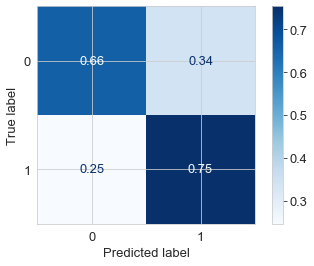

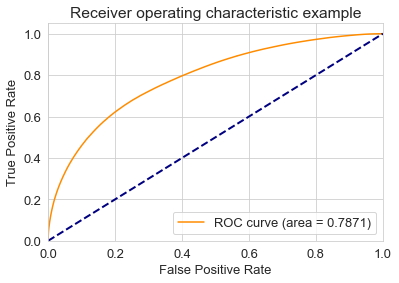

In [40]:
# Base Line Evaluation

#Predicting for testing and trainig data sets
y_test_proba = rf.predict_proba(X_test)[:,1]
y_train_proba = rf.predict_proba(X_train)[:,1]

y_pred_test = rf.predict(X_test)
y_pred_train = rf.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %rf.score(X_train, y_train))
print("Test accuracy    : %0.4f" %rf.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(rf, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


In [41]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4400000 entries, 1748203 to 1692743
Data columns (total 83 columns):
song_length                                float32
language                                   int16
city                                       int16
bd                                         int16
registered_via                             int16
lyricist_count                             int16
artist_count                               int16
composer_count                             int16
genre_count                                int16
isrc_year                                  int8
duration                                   float16
registration_year                          int16
registration_month                         int16
registration_day                           int16
registration_weekday                       int16
expiration_year                            int16
expiration_month                           int16
expiration_day                             in

Top 20 Feature Importance


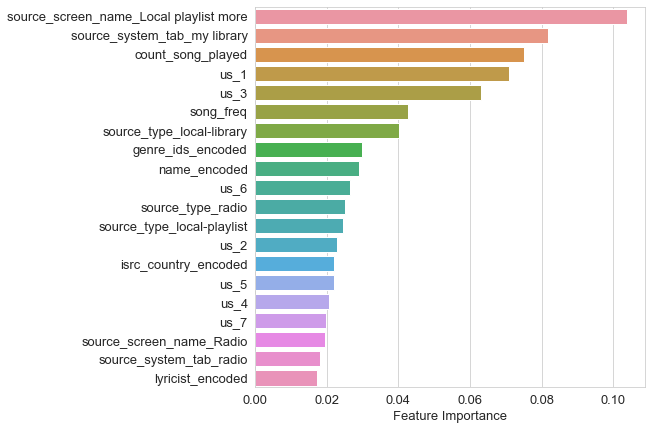

In [42]:
figsize(7,7)
import seaborn as sns
coefficients = rf.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 20 Feature Importance")
_ = sns.barplot(data = coef[:20], x = 'Feature Importance', y = coef[:20].index, orient = 'h')
#_ = plt.barh(coef[:20].index, coef['Feature Importance'][:20])

In [122]:
#diff = list(set(df.msno.iloc[X_test.index])-set(df.msno.iloc[X_train.index]))
#diff_index = X[X.msno.isin(diff)].index
len(diff_index)

139439

In [123]:
y_pred_valid = rf.predict(data_x_valid)



[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   22.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   23.5s finished


In [125]:
data_x_valid['target'] = data_y_valid
data_x_valid['pred'] = y_pred_valid
cold_start = data_x_valid#[data_x_valid.index.isin(diff_index)]

cold_start['accuracy'] = np.where(cold_start['pred'] == cold_start['target'], 1, 0)
cold_start.accuracy.value_counts(normalize=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


1    0.628117
0    0.371883
Name: accuracy, dtype: float64

In [ ]:
Results - This model (Doc to Vec)

In [18]:
def rf_classifier(X_train, X_test, n_trees):
    rf = RandomForestClassifier(n_jobs = 4, max_depth = n_trees, random_state = 42)

    rf.fit(X_train,y_train)

    y_pred_test = rf.predict(X_test)
    y_pred_train = rf.predict(X_train)
    
    y_test_proba = rf.predict_proba(X_test)[:,1]
    y_train_proba = rf.predict_proba(X_train)[:,1]


    #Accuracy Score
    auc_train = roc_auc_score(y_train,y_train_proba)
    auc_test = roc_auc_score(y_test,y_test_proba)
    #loss_train = log_loss(y_train, rf.predict_proba(X_train))
    #loss_test = log_loss(y_test, rf.predict_proba(X_test))
    
    return auc_train, auc_test
    #return loss_train, loss_test

### Hyper-parameter Tuning

In [19]:


n_trees = [20, 50, 100, 200, 500]
max_depths = [10, 15, 20, 25]
min_samples_split = [2, 10, 30,50, 75]
min_samples_leaf = [1, 2, 10, 35, 50, 75]
max_features = [4,5,6, 10, 15, 20]


train_auc = []
test_auc  = []

for i in max_depths:
    print(i)
    train, test = rf_classifier(X_train, X_test, i)
    train_auc.append(train)
    test_auc.append(test)

_ = plt.plot(max_depth, train_auc, 'r', label = 'Training')
_ = plt.plot(max_depth, test_auc, 'b', label = 'Test')
_ = plt.xlabel('Max_depth')
_ = plt.ylabel('AUC Score')


10


MemoryError: 

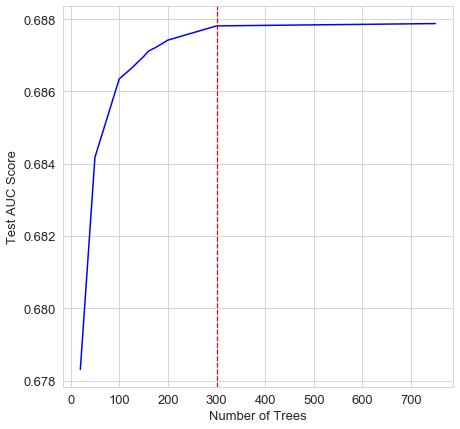

In [91]:
#_ = plt.plot(n_trees, train_auc, 'r', label = 'Training')
_ = plt.plot(n_trees, test_auc, 'b', label = 'Test')
_ = plt.xlabel('Number of Trees')
_ = plt.ylabel('Test AUC Score')
_ = plt.axvline(x = 300, color = 'r', linestyle = '--', linewidth = 1.25)

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

#n_trees = randint(100,150)
max_depths = randint(15,20)
min_samples_split = randint(20,100)
max_features = randint(15,30)

param_grid = {'max_depth': max_depths, 'min_samples_split': min_samples_split,
              'max_features':max_features } #'n_estimators':n_trees

rf = RandomForestClassifier(n_jobs = 4)

cv = RandomizedSearchCV(rf, param_distributions = param_grid, random_state=42, 
                        n_iter=150, cv=5, verbose=2, n_jobs=4, scoring = 'roc_auc')

cv.fit(X_train,y_train)

print(cv.best_params_)
print(cv.best_score_)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed: 44.6min
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed: 97.1min
[Parallel(n_jobs=4)]: Done 750 out of 750 | elapsed: 107.5min finished


{'max_depth': 18, 'max_features': 15, 'min_samples_split': 27}
0.685164570688306


In [116]:
n_trees = [75, 100, 125, 150, 175, 200]
max_depths = [10, 12, 14, 15, 16, 20]
min_samples_split = [2, 30,50, 75, 100, 150]
min_samples_leaf = [2, 35, 50, 75, 100, 150]
max_features = np.arange(6,25,3)
print(max_features)

[ 6  9 12 15 18 21 24]


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 300building tree 2 of 300building tree 3 of 300

building tree 4 of 300

building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.1s


building tree 41 of 300
building tree 42 of 300
building tree 43 of 300
building tree 44 of 300
building tree 45 of 300
building tree 46 of 300
building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82

[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    9.5s


building tree 158 of 300
building tree 159 of 300
building tree 160 of 300
building tree 161 of 300
building tree 162 of 300
building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300


[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   18.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    1.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tas

Training accuracy: 0.7406


[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


Test accuracy    : 0.6349
Training AUC Score: 0.8337
Testing AUC Score: 0.6878
Classification Report - Training
              precision    recall  f1-score   support

           0       0.72      0.84      0.78     37271
           1       0.78      0.63      0.69     32806

    accuracy                           0.74     70077
   macro avg       0.75      0.73      0.73     70077
weighted avg       0.75      0.74      0.74     70077

Classification Report - Testing
                precision    recall  f1-score   support

Not Readmitted       0.63      0.74      0.68     15937
    Readmitted       0.64      0.52      0.57     14096

      accuracy                           0.63     30033
     macro avg       0.64      0.63      0.63     30033
  weighted avg       0.64      0.63      0.63     30033



[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.5s finished


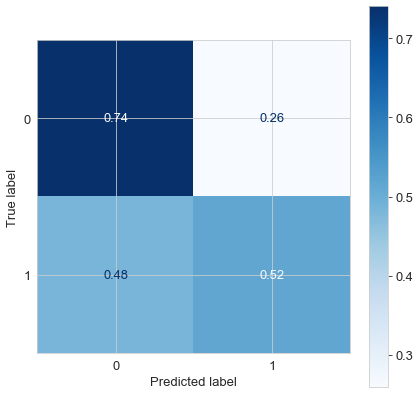

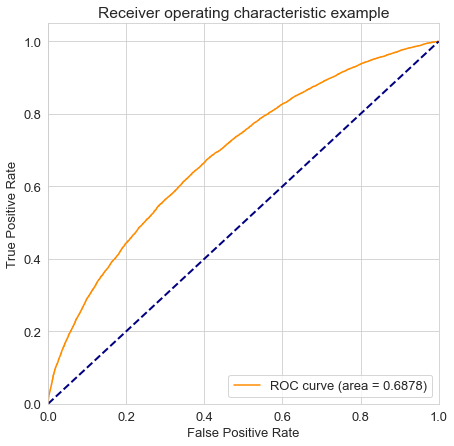

In [99]:
#best_lr = cv.best_estimator_

#best_lr.fit(X_train,y_train)

best_lr = RandomForestClassifier(n_jobs = 4, n_estimators = 300, max_features = 15,
                               max_depth = 18, min_samples_split = 27, random_state = 42, verbose = 2)
best_lr.fit(X_train, y_train)
#Predicting for testing and trainig data sets
y_test_proba = best_lr.predict_proba(X_test)[:,1]
y_train_proba = best_lr.predict_proba(X_train)[:,1]

y_pred_test = best_lr.predict(X_test)
y_pred_train = best_lr.predict(X_train)

#Accuracy Score
print("Training accuracy: %0.4f" %best_lr.score(X_train, y_train))
print("Test accuracy    : %0.4f" %best_lr.score(X_test, y_test))
#print("Test log loss    : %0.4f" %log_loss(y_train, lr.predict_proba(X_train)))
#AUC Score
auc_train = roc_auc_score(y_train,y_train_proba)
auc_test = roc_auc_score(y_test,y_test_proba)

print('Training AUC Score: %0.4f' %auc_train)  
print('Testing AUC Score: %0.4f' %auc_test)          

print('Classification Report - Training')
print(classification_report(y_train,y_pred_train))

print('Classification Report - Testing')
print(classification_report(y_test,y_pred_test,target_names = class_names))

plot_confusion_matrix(best_lr, X_test, y_test,  cmap=plt.cm.Blues, normalize = 'true') #display_labels=class_names,
plt.show()
auc_curve(y_test,y_test_proba,auc_test)


Top 25 Feature Importance


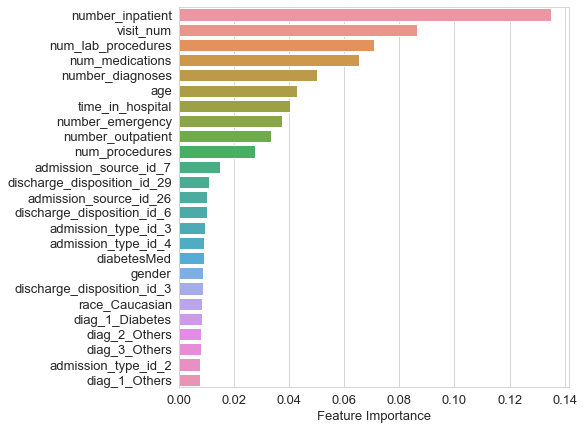

In [94]:
figsize(7,7)

coefficients = best_lr.feature_importances_
coef = pd.DataFrame(coefficients, index = X_train.columns, columns = ['Feature Importance'])
coef.sort_values('Feature Importance', ascending = False, inplace = True)
print("Top 25 Feature Importance")
_ = sns.barplot(data = coef[0:25], x = 'Feature Importance', y = coef[0:25].index, orient = 'h')
#_ = plt.barh(coef[:20].index, coef['Feature Importance'][:20])